# VoltaML  Assignment

## In this notebook, the proposed model classifies the image data into two classes (PSK and QAM). 

Importing various required libraries like tensorflow,matplotlib,numpy,keras models.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.preprocessing import image
from matplotlib import pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array
import copy
from tensorflow.keras.models import model_from_json

In [10]:
tf.__version__

'2.7.0'

In [12]:
from platform import python_version

python_version()

'3.9.6'

### The paths for the training, validation and the testing data.

In [35]:
data_dir='dataset/train'
test_data_dir='dataset/test'
val_data_dir='dataset/valid'

In [36]:
classes=[str(i) for i in range(6)]

In [37]:
train_images_per_class=500
test_images_per_class=150
valid_images_per_class=100

## Checking out some sample images for classification

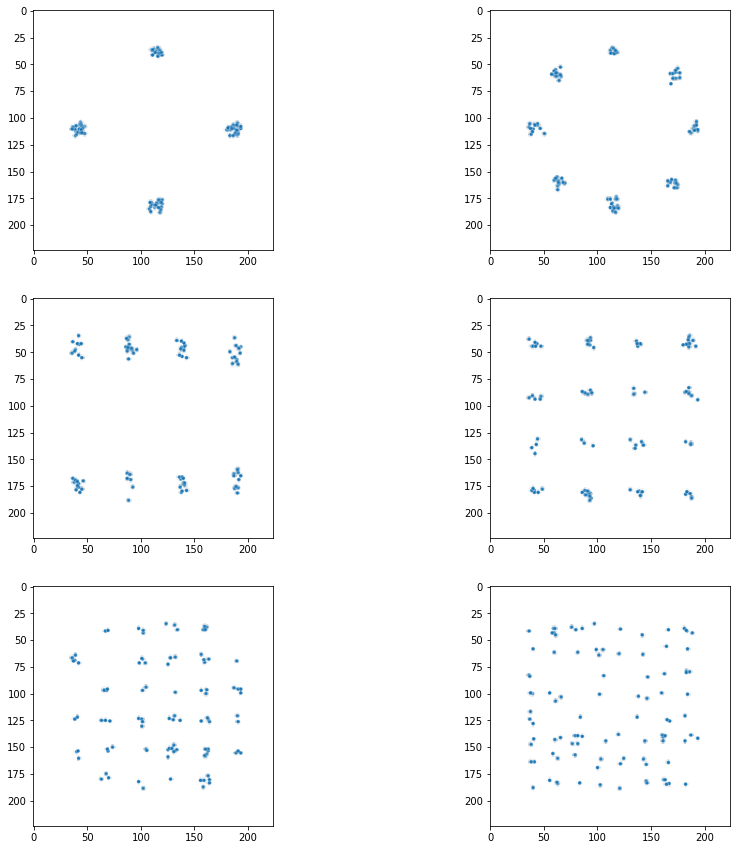

In [38]:
# Opens a image in RGB mode
newsize=(224,224)

sample_imgs=[400 for i in range(6)]
imgs=[]
for i in range(6):
  imgs.append(Image.open("dataset/train/"+str(i)+'/'+str(sample_imgs[i])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 3
columns = 2


for i in range(6):
  # Adds a subplot at the ith position
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(imgs[i])

## This is the function that fills the given values in a circle shape with specified center and diameter.
### This function is very handy in generating a circular mask.

In [39]:
def gen_circle(img: np.ndarray, center: tuple, diameter: int,fill_val: int) -> np.ndarray:
  
    """
        Creates a matrix of ones filling a circle.
    """

    # gets the radius of the image
    radius  = diameter//2

    # gets the row and column center of the image
    row, col = center 

    # generates theta vector to variate the angle
    theta = np.arange(0, 360)*(np.pi/180)

    # generates the indexes of the column
    y = (radius*np.sin(theta)).astype("int32") 

    # generates the indexes of the rows
    x = (radius*np.cos(theta)).astype("int32") 

    # with:
    # img[x, y] = 1
    # you can draw the border of the circle 
    # instead of the inner part and the border. 

    # centers the circle at the input center
    rows = x + (row)
    cols  = y + (col)

    # gets the number of rows and columns to make 
    # to cut by half the execution
    nrows = rows.shape[0] 
    ncols = cols.shape[0]

    # makes a copy of the image
    img_copy = np.copy(img)

    # We use the symmetry in our favour
    # does reflection on the horizontal axes 
    # and in the vertical axes

    for row_down, row_up, col1, col2 in zip(rows[:nrows//4],
                            np.flip(rows[nrows//4:nrows//2]),
                            cols[:ncols//4],
                            cols[nrows//2:3*ncols//4]):
    
        img_copy[row_up:row_down, col2:col1] = fill_val

    return img_copy

In [40]:
def preprocess_data(X,Y,n):
  X_p=preprocess_input(X)
  Y_p=tf.keras.utils.to_categorical(Y,n)
  return (X_p,Y_p)

## Reading the training data:

In [41]:
train_data=[]
img_height,img_width=224,224
for cls in classes:
  print(cls)
  for i in range(train_images_per_class):
    img_path=data_dir+'/'+cls+'/'+str(i)+'.png'
    imge=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=np.asarray(imge)
    train_data.append(img_data)

0
1
2
3
4
5


## Reading the Validation data:

In [42]:
valid_data=[]
img_height,img_width=224,224
for cls in classes:
  print(cls)
  for i in range(valid_images_per_class):
    img_path=val_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=np.asarray(img)
    valid_data.append(img_data)

0
1
2
3
4
5


## Converting the image data into Numpy arrays.

In [43]:
train_data=np.asarray(train_data)

In [44]:
valid_data=np.asarray(valid_data)

# **Building First stage Model:**

#### The very first stage of the model classifies the images into 2 categories, the PSK and the QAM classes.

In [45]:
classes_1=['0','1']
#'0' - PSK
#'1' - QAM

In [46]:
train_data_1=copy.deepcopy(train_data)

In [47]:
valid_data_1=copy.deepcopy(valid_data)

In [48]:
train_label_1=[]
train_label_1[:2*train_images_per_class]=['0']*2*train_images_per_class
train_label_1[2*train_images_per_class:]=['1']*4*train_images_per_class
train_label_1=np.asarray(train_label_1)

In [49]:
valid_label_1=[]
valid_label_1[:2*valid_images_per_class]=['0']*2*valid_images_per_class
valid_label_1[2*valid_images_per_class:]=['1']*4*valid_images_per_class
valid_label_1=np.asarray(valid_label_1)

## Preprocessing steps
#### Defining each type of filter applied on corresponding layer of the images:

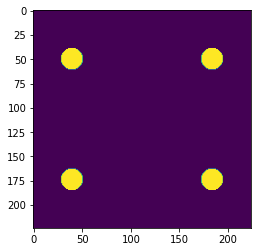

In [50]:
# R filter
#four concentric circles - centres
diam = 25
x_dis=40
y_dis=50
r_filter_dim=[(y_dis,x_dis),(224-y_dis,x_dis),(y_dis,224-x_dis),(224-y_dis,224-x_dis)]

fil=np.zeros((224,224),dtype=int)
for i in range(4):
  fil=gen_circle(fil,r_filter_dim[i],diam,1)
plt.imshow(fil)

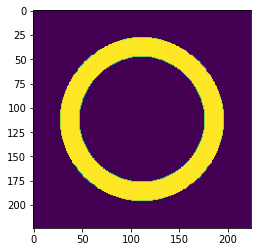

In [51]:
# G filter

# ring-outer radius and inner radius
g_filter_dim=[85,65]
val=[1,0]
fil=np.zeros((224,224),dtype=int)
for i in range(2):
  fil=gen_circle(fil,(112,112),2*g_filter_dim[i],val[i])
plt.imshow(fil)

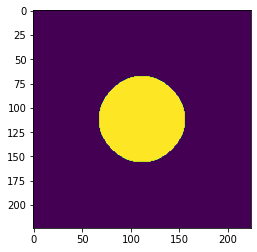

In [52]:
# B filter

# circle-diameter
b_filter_dim=90

fil=np.zeros((224,224),dtype=int)
fil=gen_circle(fil,(112,112),b_filter_dim,1)
plt.imshow(fil)

In [53]:
def apply_filter_1(im):
  '''

  '''
  center = (112,112)

  #red layer filter 
  fil=np.zeros((224,224),dtype=int)
  for i in range(4):
    fil=gen_circle(fil,r_filter_dim[i],diam,1)
  im[:,:,0]=im[:,:,0]*fil

  #blue layer filter
  fil=np.zeros((224,224),dtype=int)
  g_filter_dim=[85,65]
  val=[1,0]
  fil=np.zeros((224,224),dtype=int)
  for i in range(2):
    fil=gen_circle(fil,center,2*g_filter_dim[i],val[i])
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  fil=np.zeros((224,224),dtype=int)
  fil=gen_circle(fil,center,b_filter_dim,1)
  im[:,:,2]=im[:,:,2]*fil
  
  return im

In [54]:
def disp_filter_image_1(im):
  im=apply_filter_1(im)
  plt.imshow(im)
  plt.axis('off')

### Sample Images looks like this after the filters are being applied:

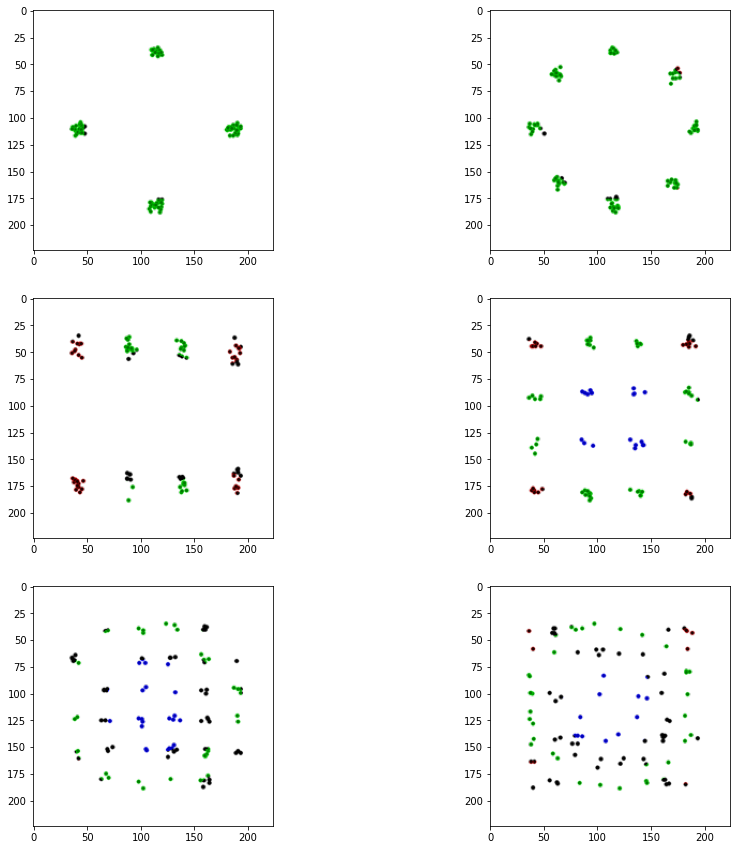

In [55]:
fil_imgs=[]
for i in range(6):
  fil_imgs.append(Image.open("dataset/train/"+str(i)+'/'+str(sample_imgs[i])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 3
columns = 2

for i in range(6):
  # Adds a subplot at the ith position
  fil_imgs[i]=apply_filter_1(np.array(fil_imgs[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(fil_imgs[i])

## Applying the Filters on Training data

In [56]:
for i in range(len(train_label_1)):
  train_data_1[i]=apply_filter_1(train_data_1[i])

## Applying the Filters on validation data

In [57]:
for i in range(len(valid_label_1)):
  valid_data_1[i]=apply_filter_1(valid_data_1[i])

In [58]:
print(valid_data_1.shape)

(600, 224, 224, 3)


In [59]:
train_data_1,train_label_1=preprocess_data(train_data_1,train_label_1,2)

In [60]:
valid_data_1,valid_label_1=preprocess_data(valid_data_1,valid_label_1,2)

In [61]:
print(train_data_1.shape,train_label_1.shape)

(3000, 224, 224, 3) (3000, 2)


In [62]:
print(valid_data_1.shape,valid_label_1.shape)

(600, 224, 224, 3) (600, 2)


## Building and training the model-1

I am using the Resnet50 Pre trained model to retrain it using the training dataset.

In [63]:
resnet_model_1 = Sequential()
input_t=tf.keras.Input(shape=(224,224,3))
pretrained_model_1= tf.keras.applications.ResNet50(include_top=False,
                   input_tensor=input_t,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model_1.layers:
        layer.trainable=False

resnet_model_1.add(pretrained_model_1)

In [64]:
resnet_model_1.add(Flatten())
resnet_model_1.add(Dense(512, activation='relu'))
resnet_model_1.add(Dense(2, activation='softmax'))

In [65]:
resnet_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [66]:
resnet_model_1.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model_1.fit(train_data_1,train_label_1, validation_data=(valid_data_1,valid_label_1),batch_size=32, epochs=5,verbose=1)

Epoch 1/5
94/94 [==============================] - 523s 5s/step - loss: 2.3944 - accuracy: 0.7953 - val_loss: 0.5132 - val_accuracy: 0.8250
Epoch 2/5
94/94 [==============================] - 362s 4s/step - loss: 0.4119 - accuracy: 0.8617 - val_loss: 0.4752 - val_accuracy: 0.8833
Epoch 3/5
94/94 [==============================] - 403s 4s/step - loss: 0.5656 - accuracy: 0.8453 - val_loss: 0.6741 - val_accuracy: 0.8500
Epoch 4/5
11/94 [==>...........................] - ETA: 4:16 - loss: 0.3979 - accuracy: 0.8892

KeyboardInterrupt: 

#### I have stopped execution here, since the accuracy has stopped to increase.

## Testing Phase of Model-1

In [67]:
test_data=[]
img_height,img_width=224,224
for cls in classes:
  print(cls)
  for i in range(test_images_per_class):
    img_path=test_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=np.asarray(img)
    test_data.append(img_data)

0
1
2
3
4
5


In [68]:
test_data_1=test_data

In [69]:
test_label_1=[]
test_label_1[:2*test_images_per_class]=[0]*2*test_images_per_class
test_label_1[2*test_images_per_class:]=[1]*4*test_images_per_class

In [70]:
test_data_1=np.asarray(test_data_1)
test_label_1=np.asarray(test_label_1)

In [71]:
for i in range(len(test_label_1)):
  test_data_1[i]=apply_filter_1(test_data_1[i])

In [72]:
test_data_1,test_label_1=preprocess_data(test_data_1,test_label_1,2)

In [73]:
test_data_1.shape,test_label_1.shape

((900, 224, 224, 3), (900, 2))

In [74]:
test_loss,test_acc=resnet_model_1.evaluate(test_data_1,test_label_1,verbose=1)

29/29 [==============================] - 90s 3s/step - loss: 0.3283 - accuracy: 0.8533


In [75]:
print('***************************************\n Testing data accuracy = '+str(test_acc)+'\n Testing data loss = '+str(test_loss)+'\n ***************************************')

Testing data accuracy = 0.8533333539962769
 Testing data loss = 0.3282844126224518


## Saving the Model to the disk

In [76]:
model_json = resnet_model_1.to_json()
with open("Models/filter_model_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnet_model_1.save_weights("Models/filter_model_1.h5")
print("Saved model to disk")


c:\python\python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk
